Images come from teh Project F Folder shared drive

Tutorials:

https://medium.com/@sidathasiri/building-a-convolutional-neural-network-for-image-classification-with-tensorflow-f1f2f56bd83b


FCN (Fully Convolutional Network) 
https://towardsdatascience.com/implementing-a-fully-convolutional-network-fcn-in-tensorflow-2-3c46fb61de3b

https://medium.com/analytics-vidhya/how-to-pick-the-optimal-image-size-for-training-convolution-neural-network-65702b880f05



Papers:

Sources from suggestions on stack exchange: https://ai.stackexchange.com/questions/6274/how-can-i-deal-with-images-of-variable-dimensions-when-doing-image-segmentation

https://arxiv.org/pdf/1505.04597.pdf

https://arxiv.org/pdf/1411.4038.pdf

https://arxiv.org/pdf/1406.4729.pdf

https://arxiv.org/pdf/1904.04514.pdf

https://arxiv.org/pdf/1612.03144.pdf

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

dataFolder = "drive/Shareddrives/Project F Folder/data/"
!cp "drive/Shareddrives/Project F Folder/data/pretty.py" "/content"
trainFolder = dataFolder + "train/"
valFolder = dataFolder + "val/"

_, _, trainImages = next(os.walk(trainFolder))
print("Found train %d images" % len(trainImages))
_, _, valImages = next(os.walk(valFolder))
print("Found val %d images" % len(valImages))


Found train 728 images
Found val 250 images


In [ ]:
# Functions

# Splits image name into artist name and image number
def parseImageName(imageName):
  splitImg = imageName.split("_")
  artist = splitImg[0]
  for i in range(1, len(splitImg) - 1): # Get the artist name
    artist += "_" + splitImg[i]
  imgNum = splitImg[-1][:-4] # Art number
  return artist, imgNum

def getImageName(artistName, imgNum):
  return artistName + "_" + str(imgNum) + ".jpg"
  
# Image Dimmensions, length by height
def getImgDim(img):
  return len(img[0]), len(img)

def aspectRatio(width, height):
  return float(width)/height

In [ ]:
# Convert artist and paths into shuffled dictionary
import random

def getArtData(images):
    # Get the list of artists, their artwork numbers, their total number of artworks and list of filenames for their art
    artists = [] # Artist names 
    artNums = [] # List of numbers of artworks (each artist gets a list)
    artCount = [] # Counts of artwork per artist
    artistFiles = []  # Filenames organized by artist (each artist gets a list)
    for image in images: 
      artist, imgNum = parseImageName(image) # Get artist name and artwork number
      if artist not in artists: # New Artist
        artists.append(artist)
        artNums.append([imgNum])
        artistFiles.append([image])
        artCount.append(0)
      else: # Old Artist
        index = artists.index(artist)
        artNums[index].append(imgNum)
        artistFiles[index].append(image)
        artCount[index] += 1
    return artists, artNums, artCount, artistFiles

def getDataAsDict(images, shuffle=True):
    artEntries = []
    artists, artNums, artCount, artistFiles = getArtData(images)
    numArtists = len(artists)
    for i in range(numArtists):
        artist = artists[i]
        print(artist,artistFiles[i][0])
        for j in range(len(artistFiles[i])):
            entry = {"artist": artist, "artPath":artistFiles[i][j]}
            #print(entry)
            artEntries.append(entry)
    if shuffle:
        random.shuffle(artEntries)
    return artEntries, numArtists

trainArtEntries, numArtists = getDataAsDict(trainImages)
print("Num Train Artworks %d" % len(trainArtEntries))
print()


valArtEntries, numArtists = getDataAsDict(valImages)
print("Num Val Artworks %d" % len(valArtEntries))

Vincent_van_Gogh Vincent_van_Gogh_686.jpg
Pablo_Picasso Pablo_Picasso_31.jpg
Albrecht_Duerer Albrecht_Duerer_130.jpg
Pierre-Auguste_Renoir Pierre-Auguste_Renoir_164.jpg
Edgar_Degas Edgar_Degas_684.jpg
Num Train Artworks 728

Vincent_van_Gogh Vincent_van_Gogh_797.jpg
Pablo_Picasso Pablo_Picasso_58.jpg
Albrecht_Duerer Albrecht_Duerer_72.jpg
Pierre-Auguste_Renoir Pierre-Auguste_Renoir_180.jpg
Edgar_Degas Edgar_Degas_105.jpg
Num Val Artworks 250


In [ ]:
# Load images and prepare them for model inputs

import numpy as np
import cv2
import tensorflow as tf

def loadImgset(folder, mySet):
    imgSet = []
    labels = []
    count = 0
    for art in mySet:
        myPath = art["artPath"]
        label = art["artist"]
        
        img = cv2.imread(folder + myPath)
        img = cv2.resize(img, (224,224))
        img = np.array(img)
        img = img.astype("float32")
        img /= 255
        
        imgSet.append(img)
        labels.append(label)
        count += 1
        if count % 10 == 0:
          print("Processed ", count, " of ", len(mySet))
    
    return imgSet, labels
 
def convertLabelsToOneShot(labels):
    labelMappings= {k: v for v, k in enumerate(np.unique(labels))}
    labelsAsInts =  [labelMappings[labels[i]] for i in range(len(labels))]
    oneShot = tf.keras.utils.to_categorical(labelsAsInts)
    return labelMappings, oneShot, np.array(labelsAsInts)

# Train Set
trainX, trainY = loadImgset(trainFolder, trainArtEntries)
trainXX = np.array(trainX, np.float32)
labelMapping, trainOneShot, trainYInts = convertLabelsToOneShot(trainY)
print(trainXX.shape)
print(trainOneShot.shape)

# Validation Set
valX, valY = loadImgset(valFolder, valArtEntries)
valXX = np.array(valX, np.float32)
labelMapping2, valOneShot, valYInts = convertLabelsToOneShot(valY)
print(valXX.shape)
print(valOneShot.shape)

print(labelMapping)
print(valYInts)
if labelMapping != labelMapping2:
    raise Exception("Somthing is wrong with the one shot transform")

Processed  10  of  728
Processed  20  of  728
Processed  30  of  728
Processed  40  of  728
Processed  50  of  728
Processed  60  of  728
Processed  70  of  728
Processed  80  of  728
Processed  90  of  728
Processed  100  of  728
Processed  110  of  728
Processed  120  of  728
Processed  130  of  728
Processed  140  of  728
Processed  150  of  728
Processed  160  of  728
Processed  170  of  728
Processed  180  of  728
Processed  190  of  728
Processed  200  of  728
Processed  210  of  728
Processed  220  of  728
Processed  230  of  728
Processed  240  of  728
Processed  250  of  728
Processed  260  of  728
Processed  270  of  728
Processed  280  of  728
Processed  290  of  728
Processed  300  of  728
Processed  310  of  728
Processed  320  of  728
Processed  330  of  728
Processed  340  of  728
Processed  350  of  728
Processed  360  of  728
Processed  370  of  728
Processed  380  of  728
Processed  390  of  728
Processed  400  of  728
Processed  410  of  728
Processed  420  of  728
P

In [ ]:
#!pip install tensorflow-addons
#import tensorflow_addons as tfa
import tensorflow as tf

from tensorflow.keras import layers

Metrics = ["acc","Precision", "Recall"]

def CNNModel():
    model = tf.keras.Sequential([
        layers.Conv2D(filters=32, kernel_size=3, strides=(3,3), activation="relu", input_shape=(224, 224, 3)),
        layers.MaxPooling2D(pool_size = (2,2)),
        layers.Conv2D(filters=64, kernel_size=3, strides=(3,3), activation="relu"),
        layers.MaxPooling2D(pool_size = (2,2)),
        #tfa.layers.SpatialPyramidPooling2D([1,3]),
        layers.Flatten(),
        layers.Dense(512, activation="relu"),
        #layers.Dropout(.5),
        #layers.BatchNormalization(),
        layers.Dense(numArtists, activation="softmax")
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
        loss='categorical_crossentropy',
        metrics=Metrics)
    return model

def PyramidModel():
    model = tf.keras.Sequential([
        layers.Conv2D(filters=32, kernel_size=3, strides=(3,3), activation="relu", input_shape=(224, 224, 3)),
        layers.MaxPooling2D(pool_size = (2,2)),
        layers.Conv2D(filters=64, kernel_size=3, strides=(3,3), activation="relu"),
        layers.MaxPooling2D(pool_size = (2,2)),
        #tfa.layers.SpatialPyramidPooling2D([1,3]),
        layers.Flatten(),
        layers.Dense(512, activation="relu"),
        #layers.Dropout(.5),
        #layers.BatchNormalization(),
        layers.Dense(numArtists, activation="softmax")
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
        loss='categorical_crossentropy',
        metrics=Metrics)
    return model

def FCN():
    model = tf.keras.Sequential([
        layers.Conv2D(filters=16, kernel_size=3, strides=(4,4), activation="relu", input_shape=(None, None, 3)),
        layers.BatchNormalization(),
        #layers.MaxPooling2D(pool_size = (2,2)),
        layers.Conv2D(filters=32, kernel_size=5, strides=(4,4), activation="relu", input_shape=(None, None, 3)),
        layers.BatchNormalization(),
        #layers.MaxPooling2D(pool_size = (2,2)),
        #layers.Conv2D(filters=64, kernel_size=5, strides=(5,5), activation="relu", input_shape=(None, None, 3)),
        #layers.BatchNormalization(),
        #layers.MaxPooling2D(pool_size = (2,2)),
        layers.Conv2D(numArtists, kernel_size=1),
        #layers.GlobalMaxPooling2D(),
        layers.Activation("softmax")
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
        loss='categorical_crossentropy',
        metrics=Metrics)
    return model


Epoch 1/100
23/23 [==============================] - 5s 161ms/step - loss: 1.4327 - acc: 0.3420 - precision: 0.6941 - recall: 0.0810 - val_loss: 1.2936 - val_acc: 0.3760 - val_precision: 0.6049 - val_recall: 0.1960
Epoch 2/100
23/23 [==============================] - 3s 139ms/step - loss: 1.1754 - acc: 0.4959 - precision: 0.7639 - recall: 0.2266 - val_loss: 1.1572 - val_acc: 0.5080 - val_precision: 0.7349 - val_recall: 0.2440
Epoch 3/100
23/23 [==============================] - 3s 139ms/step - loss: 1.0463 - acc: 0.5934 - precision: 0.7738 - recall: 0.3242 - val_loss: 1.0220 - val_acc: 0.5160 - val_precision: 0.7944 - val_recall: 0.3400
Epoch 4/100
23/23 [==============================] - 3s 136ms/step - loss: 0.9446 - acc: 0.6415 - precision: 0.8005 - recall: 0.4354 - val_loss: 1.0345 - val_acc: 0.5520 - val_precision: 0.7542 - val_recall: 0.3560
Epoch 5/100
23/23 [==============================] - 3s 135ms/step - loss: 0.8467 - acc: 0.6923 - precision: 0.8164 - recall: 0.5192 - val_l

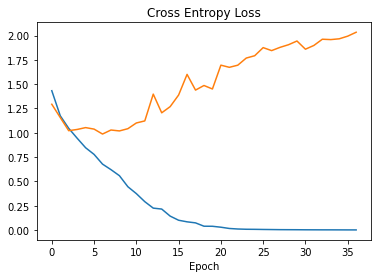

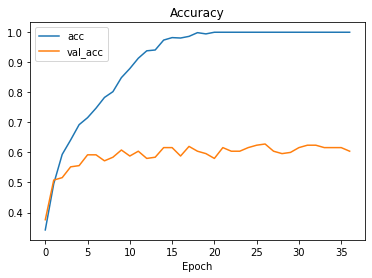

In [ ]:
# Create and Fit Model

import matplotlib.pyplot as plt
myModel = CNNModel()

earlystopping = tf.keras.callbacks.EarlyStopping(monitor="val_acc", patience=10,restore_best_weights=True, verbose=1)
history = myModel.fit(trainXX, trainOneShot, validation_data = (valXX, valOneShot), epochs=100, verbose = 1, shuffle = True,
                     callbacks=[earlystopping])


def plot_loss(history, lossOnly=False):
    plt.figure()
    plt.title("Cross Entropy Loss")
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')

    plt.figure()
    plt.title("Accuracy")
    plt.plot(history.history['acc'], label='acc')
    plt.plot(history.history['val_acc'], label='val_acc')
    plt.xlabel('Epoch')
    #plt.ylabel('Error')
    plt.legend()
plot_loss(history)




In [ ]:
#Evaluate the overall model and by artist here

def f1Score(prec, recall):
    return 2*(prec*recall)/(prec + recall)

def nList(n):
    myList = []
    for i in range(n):
        myList.append([])
    return myList

# Returns dict of artists along with x and y one shot data
# in nd list (orgianized by artist)
def getValDataByClass(dataX, dataY, oneShot, labelMap):
    artists = labelMap.keys()

    xList = nList(len(artists))
    yList = nList(len(artists))
    for i in range(len(dataY)):
        artist = dataY[i]
        index = labelMap[artist]
        xList[index].append(dataX[i])
        yList[index].append(oneShot[i])
    return artists, np.array(xList), np.array(yList)
    
# Evaluates the models for various metrics, expects the input x and one shot y data
def evaluateModel(x,y):
    loss, acc, precision, recall = myModel.evaluate(x, y)
    f1 = f1Score(precision, recall)
    print("Loss:      ", loss)
    print("Accuracy:  ", acc)
    print("Precision: ", precision)
    print("Recall:    ", recall)
    print("F1:        ", f1)
    print()
  
# Evaluate the Overall Model
print("Overall Model")
evaluateModel(valXX, valOneShot)

# Evaluate By Artist
valArtists, valXXByClass, valYByClass = getValDataByClass(valX, valY, valOneShot, labelMapping)
for i in range(len(valArtists)):
    print(list(valArtists)[i])
    evaluateModel(valXXByClass[i], valYByClass[i])
    
    

Overall Model
8/8 [==============================] - 0s 38ms/step - loss: 1.8450 - acc: 0.6280 - precision: 0.6325 - recall: 0.5920
Loss:       1.8449913263320923
Accuracy:   0.628000020980835
Precision:  0.632478654384613
Recall:     0.5920000076293945
F1:         0.611570262245757

Albrecht_Duerer
2/2 [==============================] - 0s 23ms/step - loss: 0.3240 - acc: 0.9000 - precision: 0.9184 - recall: 0.9000
Loss:       0.32396039366722107
Accuracy:   0.8999999761581421
Precision:  0.918367326259613
Recall:     0.8999999761581421
F1:         0.9090908867961812

Edgar_Degas
2/2 [==============================] - 0s 24ms/step - loss: 2.9260 - acc: 0.4600 - precision: 0.4773 - recall: 0.4200
Loss:       2.926027297973633
Accuracy:   0.46000000834465027
Precision:  0.47727271914482117
Recall:     0.41999998688697815
F1:         0.44680849965636465

Pablo_Picasso
2/2 [==============================] - 0s 24ms/step - loss: 2.9446 - acc: 0.5200 - precision: 0.4894 - recall: 0.4600
Loss

/content/pretty.py:168: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/content/pretty.py:169: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/content/pretty.py:171: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/content/pretty.py:172: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False


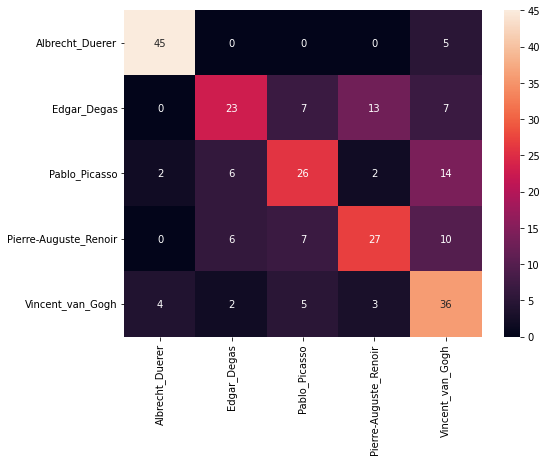

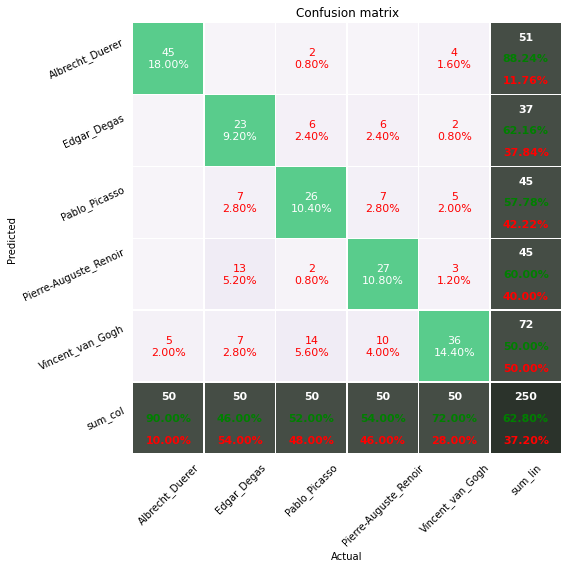

In [ ]:
# Need to place the pretty.py file into your content folder for this to work
import pretty
import pandas as pd
import seaborn as sn

def confusionPlot(y, pred, numClasses, classes):
    confusion = tf.math.confusion_matrix(y, pred, num_classes=numClasses)
    confusionArray = confusion.numpy()
    df_cm = pd.DataFrame(confusionArray, classes, classes)
    plt.figure(figsize=(8, 6))
    sn.heatmap(df_cm, annot=True)  # font size
    plt.xlim([0, numClasses])
    plt.ylim([numClasses, 0])

    pretty.pretty_plot_confusion_matrix(df_cm, cmap="PuRd")
    plt.xlim([0, numClasses+1])
    plt.ylim([numClasses+1, 0])
    
valPred = myModel.predict(valXX)
valPredArray = np.argmax(valPred, axis=1)
confusionPlot(valYInts, valPredArray, numArtists, list(valArtists))

